##Loader

In [ ]:
!pip install latextable
!pip install names
!pip install num2words

  Created wheel for latextable: filename=latextable-0.2.1-py3-none-any.whl size=6243 sha256=8a2610baa7a07b5033dcb0855b3a53eab551028bd0e4820616c069186ddaedb8
  Stored in directory: /root/.cache/pip/wheels/51/dc/99/540a81a40d112def87a9a200851a58d1ed6a866cfab4e93e56
Successfully built latextable
     |████████████████████████████████| 789 kB 5.3 MB/s 
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=ecbf014ff05414dda229f5dbdfa619221acb7f16377526f1ff0046c805c4febc
  Stored in directory: /root/.cache/pip/wheels/05/ea/68/92f6b0669e478af9b7c3c524520d03050089e034edcc775c2b
Successfully built names
     |████████████████████████████████| 101 kB 3.9 MB/s 


In [ ]:
import random
from random import randint, choice, sample

import latextable
from texttable import Texttable

from sympy import *

variables = 'a b c d m n p q r s t w x y'
variables = symbols(variables, real=True)
variables += (Symbol('z'),)
a,b,c,d,m,n,p,q,r,s,t,w,x,y,z = variables

###Functions and sequences

In [ ]:
class LinFunc():
    """
    Represent a linear function.

    Attributes
    ----------
        slope : number (int, float, or Rational)
        intercept : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, slope, pt, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from slope and y-intercept.

        Parameters
        ----------
            slope : number (int, float, or Rational)
            pt : number or list
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.slope, pt = sympify([slope, pt])
        
        self.intercept = pt[1] - pt[0]*self.slope if type(pt)==list else pt
        self.expr = self.slope*variable + self.intercept

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted slope-intercept form."""
        
        if self.slope in [0,1]:
            slopeInt = ''
        elif self.slope == -1:
            slopeInt = '-'
        else:
            slopeInt = latexify(self.slope, self.precision)
        slopeInt += latex(self.variable) if self.slope!=0 else '' 
        
        intercept = latexify(self.intercept, self.precision)
        if self.intercept>0 and self.slope!=0:
            slopeInt += ' + '
        if self.intercept!=0 or self.slope==0:
            slopeInt += intercept
            
        return slopeInt
    
    @classmethod
    def fromPts(cls, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2 = sympify([pt1, pt2])
        
        slope = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])
        
        if pt1[0]==0:
            return cls(slope, pt1[1], variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(slope, pt2[1], variable, label, domain, precision)
        else:
            return cls(slope, pt1, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        if self.slope == 0:
            return self.domain if output==self.intercept else None
        else:
            return (sympify(output)-self.intercept)/self.slope

    def getSlopeInt(self, notation='func'):
        """Return LaTeX formatted slope-intercept form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    def getPtSlope(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-slope form.
        
        Parameters
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        if type(pt)!=list:
            pt = [pt] + [self.subs(pt)]
        
        ptTex = latexify(pt, self.precision)
        
        if self.slope in [0,1]:
            ptSlope = ''
        elif self.slope == -1:
            ptSlope = '-'
        else:
            ptSlope = latexify(self.slope, self.precision)
            
        if self.slope!=0:
            ptSlope += r'\left(' + latex(self.variable)
            ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            ptSlope += r'\right)'
        
        if pt[1]>0 and self.slope!=0:
            ptSlope += ' + '
        if pt[1]!=0 or self.slope==0:
            ptSlope += ptTex[1]
        
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptSlope
        else:
            return notation + '=' + ptSlope
            
    def getStdForm(self, notation='y', mult=1):
        if self.slope == 0:
            mult = nsimplify(self.intercept).q
        elif self.intercept == 0:
            mult = nsimplify(self.slope).q
        else:
            mult *= abs(lcm(nsimplify(self.slope).q, nsimplify(self.intercept).q))
        mult = -mult if self.slope<=0 else mult
        
        stdForm = latex(nsimplify(mult*self.slope*self.variable - mult)) + notation
        stdForm += '=' + latex(nsimplify(-mult*self.intercept))
        
        return stdForm
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class ExpFunc():
    """
    Represent an exponential function.

    Attributes
    ----------
        base : number (int, float, or Rational)
        intercept : number
        shift : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, base, pt, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from base, point/y-int, and vertical shift.

        Parameters
        ----------
            base : number (int, float, or Rational)
            intercept : number
            shift : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """

        self.base, pt, self.shift = sympify([base, pt, shift])

        self.lead = (pt[1]-self.shift)/Pow(self.base,pt[0]) if type(pt)==list else pt-self.shift
        self.expr = self.lead*(self.base**variable) + self.shift

        self.intercept = self.lead + self.shift
        
        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""

        if self.lead == 1:
            string = ''
        elif self.lead == -1:
            string = '-'
        else:
            string = latexify(self.lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                string += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            string += fr'({base})^{self.variable}'
        else:            
            string += latex(self.base**self.variable)

        if self.shift != 0:
            string += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        return string
    
    @classmethod
    def fromPts(cls, pt1, pt2, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """
        
        pt1, pt2, shift = sympify([pt1, pt2, shift])
        
        base = Pow((pt2[1]-shift)/(pt1[1]-shift), 1/(pt2[0]-pt1[0]))
        
        if pt1[0]==0:
            return cls(base, pt1[1], shift, variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(base, pt2[1], shift, variable, label, domain, precision)
        else:
            return cls(base, pt1, shift, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        """Return preimage of given output."""
        
        soln = log((sympify(output)-self.shift)/self.lead, self.base)

        return soln if soln in S.Reals else None
    
    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)
    
    def getBaseInt(self, notation='func'):
        """Return LaTeX formatted base-intercept form."""

        return self.getStdForm(notation)

    def getPtBase(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-base form.
        
        Parameter
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        pt, lead = [pt, self.subs(pt)-self.shift] if type(pt) not in [list,tuple] else [pt[0], pt[1]-self.shift]
         
        if lead == 1:
            ptBase = ''
        elif lead == -1:
            ptBase = '-'
        else:
            ptBase = latexify(lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                ptBase += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            ptBase += fr'({base})^' + r'{' + latex(self.variable-pt) + r'}'
        else:
            ptBase += latex(self.base**(self.variable - pt))
        
        if self.shift != 0:
            ptBase += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptBase
        else:
            return notation + '=' + ptBase
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class QuadFunc():
    """
    Represent a quadratic function.

    Attributes
    ----------
        aa : number (int, float, or Rational)
        bb : number
        cc : number
        
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, aa, bb, cc, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from coefficients.

        Parameters
        ----------
            aa : number (int, float, or Rational)
            bb : number
            cc : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.aa, self.bb, self.cc = sympify([aa, bb, cc])
        
        self.expr = self.aa*variable**2 + self.bb*variable + self.cc

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""
        
        if self.aa in [0,1]:
            stdForm = ''
        elif self.aa == -1:
            stdForm = '-'
        else:
            stdForm = latexify(self.aa, self.precision)
        stdForm += latex(self.variable**2) if self.aa!=0 else '' 
        
        bb = latexify(self.bb, self.precision)
        if self.bb>0 and self.aa!=0:
            stdForm += ' + '
        if self.bb == -1:
            stdForm += ' - '
        elif self.bb not in [0,1]:
            stdForm += bb
        stdForm += latex(self.variable) if self.bb!=0 else ''
            
        cc = latexify(self.cc, self.precision)
        if self.cc>0 and (self.aa!=0 or self.bb!=0):
            stdForm += ' + '
        if self.cc!=0 or (self.aa==0 and self.bb==0):
            stdForm += cc
            
        return stdForm
    
    @classmethod
    def fromVertex(cls, aa, vertex, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and vertex.

        Parameters
        ----------
            aa : number
            vertex : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, hh, kk = sympify([aa, *vertex])
        
        return cls(aa, -2*aa*hh, a*hh**2+kk, variable, label, domain, precision)
    
    @classmethod
    def fromRoots(cls, aa, root1, root2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and roots.

        Parameters
        ----------
            aa : number
            root1, root2 : numbers
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, root1, root2 = sympify([aa, root1, root2])
        
        return cls(aa, -aa*(root1+root2), a*root1*root2, variable, label, domain, precision)
    
    @classmethod
    def from2Pts(cls, aa, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and 2 points.

        Parameters
        ----------
            aa : number
            pt1, pt2 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, pt1, pt2 = sympify([aa, pt1, pt2])

        expr = aa*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1]])
        
        return cls(aa, coeffs[b], coeffs[c], variable, label, domain, precision)
    
    @classmethod
    def from3Pts(cls, pt1, pt2, pt3, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from 3 points.

        Parameters
        ----------
            pt1, pt2, pt3 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2, pt3 = sympify([pt1, pt2, pt3])

        expr = a*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1], expr.subs(x,pt3[0])-pt3[1]])
        
        return cls(coeffs[a], coeffs[b], coeffs[c], variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        return solve(self.expr.subs(self.variable,z)-output)

    def getVertex(self):
        hh = -Rational(self.bb,2*self.aa)
        return [hh, self.subs(hh)]

    def getRoots(self):
        return self.solve(0)

    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    # def getPtSlope(self, pt=1, notation='func'):
        # """
        # Return LaTeX formatted point-slope form.
        
        # Parameter
        # ---------
            # pt : number or list/tuple
                # Independent variable value or ordered pair.
        # """

        # pt = sympify(pt)
        # if type(pt)!=list:
            # pt = [pt] + [self.subs(pt)]
        
        # ptTex = latexify(pt, self.precision)
        
        # if self.slope in [0,1]:
            # ptSlope = ''
        # elif self.slope == -1:
            # ptSlope = '-'
        # else:
            # ptSlope = latexify(self.slope, self.precision)
            
        # if self.slope!=0:
            # ptSlope += r'\left(' + latex(self.variable)
            # ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            # ptSlope += r'\right)'
        
        # if pt[1]>0 and self.slope!=0:
            # ptSlope += ' + '
        # if pt[1]!=0 or self.slope==0:
            # ptSlope += ptTex[1]
        
        # if notation == 'func':
            # return fr'{self.label}({self.variable}) = ' + ptSlope
        # else:
            # return notation + '=' + ptSlope
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class PWFunc():
    """
    Represent a piecewise function.

    Attributes
    ----------
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set
    """

    def __init__(self, *pairs, variable=x, label='f'):
        """
        Construct piecewise function object from expr-interval pairs.

        Parameters
        ----------
            pairs : array of expr-interval pairs
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        self.variable = variable
        self.label = label
        
        exprs, intervals = zip(*pairs)
        intervals = list(map(makeInterval, intervals))
        self.pairs = list(zip(exprs, intervals))
        
        pieces = [[row[0], Contains(variable, row[1])] for row in self.pairs]
        self.expr = Piecewise(*pieces)
        
        self.domain = Union(*intervals)
    
    def __str__(self):
        """Return LaTeX."""
        # TODO: relational instead of intervals

        return fr'{self.label}({self.variable}) = ' + latex(self.expr)

    def subs(self, input):
        """Return evaluation of function at input."""

        return nsimplify(self.expr.subs(self.variable, input))

    def subSet(self, preimage):
        """Return image of set."""
        
        image = S.EmptySet
        for expr, interval in self.pairs:
            image = Union(image, ImageSet(Lambda(self.variable,expr),interval.intersect(preimage)))

        return image.intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        image = S.EmptySet
        for expr, interval in self.pairs:
            image = Union(image, ImageSet(Lambda(self.variable,expr),interval))

        return image.intersect(S.Reals)
        
    def solve(self, output):
        """Return preimage of given output."""
        solns = []
        
        for expr, interval in self.pairs:
            strings = solve(expr-output, self.variable)
            for ans in strings:
                if ans in interval:
                    solns.append(ans)
        
        return list(set(solns))
    
    def getLatex(self):
        """Return LaTeX."""

        return str(self)

    def getFeats(self, feats='all'):           # TODO: INC/DEC
        feats = ['domain','range','intercepts','extrema','change'] if feats=='all' else feats

        features = dict()
        if 'domain' in feats:
            features['domain'] = self.domain
        if 'range' in feats:
            features['range'] = self.getRange()
        if 'intercepts' in feats:
            features['yint'] = self.subs(0) if 0 in self.domain else None
            features['xints'] = self.solve(0)
        if 'extrema' in feats:
            rangeset = self.getRange()
            features['mins'] = [self.solve(rangeset.inf), rangeset.inf]
            features['maxes'] = [self.solve(rangeset.sup), rangeset.sup]
        if 'change' in feats:
            features.update({'inc': EmptySet, 'dec': EmptySet, 'const': EmptySet})
            for expr, interval in self.pairs:
                deriv = diff(expr,self.variable).subs(self.variable,z)
                if deriv.is_constant():
                    if deriv > 0:
                        features['inc'] = Union(features['inc'], interval)
                    elif deriv < 0:
                        features['dec'] = Union(features['dec'], interval)
                    else:
                        features['const'] = Union(features['const'], interval)
                else:
                    inc = Intersection(solve(deriv>0,self.variable).as_set(), interval)
                    features['inc'] = Union(features['inc'], inc)
                    features['dec'] = Union(features['dec'], interval-inc.closure)

        return features

    def printFeats(self, feats='all'):
        feats = ['domain','range','intercepts','extrema','change'] if feats=='all' else feats
        
        features, string = self.getFeats(feats), ''
        if 'domain' in feats:
            string += 'Domain: ' + signify(latexify(features['domain'])) + r' \newline '
        if 'range' in feats:
            string += 'Range: ' + signify(latexify(features['range'])) + r' \newline '

        if 'intercepts' in feats:
            string += '$y$-intercept: '
            if features['yint']==None:
                string += r'None \newline '
            else:
                string += signify(f'(0, {latexify(features["yint"])})') + r' \newline '

            string += '$x$-intercept(s): '
            if len(features['xints']) == 0:
                string += r'None \newline '
            else:
                xints = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['xints']]
                string += signify(', '.join([f'({latexify(jj)}, 0)' for jj in xints])) + r' \newline '

        if 'extrema' in feats:
            features['mins'][1] = features['mins'][1] if type(features['mins'][1]) in [int,Integer] else float(features['mins'][1])
            string += 'Minimum: '
            if len(features['mins'][0]) > 0:
                mins = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['mins'][0]]
                string += signify(latexify(features['mins'][1])) + ', occurs at $x=' + ', '.join([latexify(jj) for jj in mins]) + r'$ \newline '
            else:
                string += 'None (approaches ' + signify(latexify(features['mins'][1])) + r') \newline '
                
            features['maxes'][1] = features['maxes'][1] if type(features['maxes'][1]) in [int,Integer] else float(features['maxes'][1])
            string += 'Maximum: '
            if len(features['maxes'][0]) > 0:
                maxes = [jj if type(jj) in [int,Integer] else float(jj) for jj in features['maxes'][0]]
                string += signify(latexify(features['maxes'][1])) + ', occurs at $x=' + ', '.join([latexify(jj) for jj in maxes]) + r'$ \newline '
            else:
                string += 'None (approaches ' + signify(latexify(features['maxes'][1])) + r') \newline '

        if 'change' in feats:
            string += 'Increasing: ' + (signify(latexify(features['inc'])) if features['inc']!=EmptySet else 'None') + r'\newline '
            string += 'Decreasing: ' + (signify(latexify(features['dec'])) if features['dec']!=EmptySet else 'None') + r'\newline '
            string += 'Constant: ' + (signify(latexify(features['const'])) if features['const']!=EmptySet else 'None') + r'\newline '
        
        return string

In [ ]:
class ArithSeq(LinFunc):
    """
    Represent an arithmetic sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common difference.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : LinFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct arithmetic sequence object from common difference and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common difference.
            pt : number or list
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)
        
        self.common = self.slope
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return dict of terms."""

        minNum = min(self.terms.keys())
        maxNum = max(self.terms.keys())
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1] + self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = self.terms[jj+1] - self.common
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getSlopeInt() if term==0 else self.getPtSlope(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {self.label}(n-1)'
        if self.common >= 0:
            recursive += ' + ' + latexify(self.common, self.precision)
        else:
            recursive += latexify(self.common, self.precision)
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'

class GeoSeq(ExpFunc):
    """
    Represent a geometric sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common ratio.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : ExpFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct geometric sequence object from common ratio and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common ratio.
            start : number
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)

        self.common = self.base
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return list of terms."""

        minNum = int(min(self.terms.keys()))
        maxNum = int(max(self.terms.keys()))
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1]*self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = Rational(self.terms[jj+1],self.common)
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getBaseInt() if term==0 else self.getPtBase(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {latexify(self.common, self.precision)}\cdot {self.label}(n-1)'
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'


###Generators and printers

In [ ]:
def chooseFloat(package):
  floatA = random.choice(package)
  return floatA

def getFloat(min=-10,max=10,roundby=2):
  return round(random.uniform(min, max), roundby)

def getInt(min= -4, max = 4, exclude=[0]):
  intA = random.choice([x for x in range(min,max+1) if x not in exclude])
  return sympify(intA)

def getVar(exclude=None):
  return random.choice([vrbl for vrbl in variables if vrbl not in exclude])

def getFrac(denommin= -4, denommax= 4, numermin = 1, numbermax = 4 , exclude = 0):# exclude 1 in denom later
  top = random.choice([x for x in range(numermin,numbermax+1) if x != exclude])
  bot = random.choice([x for x in range(denommin,denommax+1) if x != exclude])
  return latex(simplify(Rational(top,bot),evaluate=False))

"""###Table"""

def tableGenerator(header, rows, cols_align=None, cols_valign=None, expr='latex', table_env=False, stretch=1.5):
    """
    Generate a table.

    Parameters
    ----------
        header : list or tuple
        rows : 2-dimensional array
        cols_align : list or tuple, default=None
            List of column alignments ('l','c', or 'r'); if ``None``, all set to 'c'.
        expr : str, default='latex'
            LaTeX formatted.
        table_env : boolean, default=True
            Enclose in floating table environment (\begin{table}...).

    Returns
    -------
        str
    """

    table = Texttable()
    if cols_align == None:
        cols_align = len(header)*['c']
    if cols_valign == None:
        cols_valign = len(header)*['m']
    table.set_cols_align(cols_align)
    table.set_cols_valign(cols_valign)
    table.add_rows([header] + rows)

    if expr == 'latex':
        table = latextable.draw_latex(table)
        if not table_env:
            table = table.replace('\\begin{table}\n','').replace('\n\\end{table}','')
        if stretch == 1:
            return table
        else:
            return r'{\renewcommand{\arraystretch}' + brackify(stretch) + table + r'}'
    else:
        return table.draw()
        
def makeInterval(string):
    if type(string)==Interval:
        return string
    left_open = (string[0]=='(')
    right_open = (string[-1]==')')
    start, end = sympify(string[1:-1].split(','))
    return Interval(start, end, left_open, right_open)

In [ ]:
def signify(data):
    if type(data)==list:
        return [signify(jj) for jj in data]
    else:
        return '$' + str(data) + '$'
    
def latexify(data, precision=2):
    if type(data)==list:
        return [latexify(num, precision) for num in data]
    elif type(data)==dict:
        return {k:latexify(v, precision) for k,v in data.items()}
    elif type(data) in [Integer,int]:
        return f'{int(data):,}'
    elif type(data) in [Float,float]:
        return f'{data:,.{precision}f}'
    elif type(data)==Rational and abs(data.q)>999:
        return f'{Float(data):,.{precision}f}'
    elif type(data)==Mul:
        a,b,c = Wild('a'),Wild('b'),Wild('c')
        data = data.match(a*b**c)
        data = data[a]*UnevaluatedExpr(real_root(data[b],data[c].q))**data[c].p
        return latex(data)
    elif isinstance(data, Set):
        return latex(data) if data.boundary.is_subset(Integers) else latex(N(data,precision+1))
    elif type(data)==str:
        return data
    else:
        return latex(data)

def brackify(data):
    return r'{' + str(data) + r'}'
        
def minipagify(left, right, vspace='0.25in'):
    string = '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += left + '\n\\end{minipage}\n'
    string += '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += right + '\n\\end{minipage}\n\n'
    string += f'\\vspace{brackify(vspace)}\n'
    return string

###Graphers

In [ ]:
def startGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    xstart = 5*(xmin//5)
    ystart = 5*(ymin//5)
    xtick = brackify(f'{xstart},{xstart+5},...,{xmax+5}')
    ytick = brackify(f'{ystart},{ystart+5},...,{ymax+5}')

    tex = r'\begin{tikzpicture}\begin{axis}[mmt axis style,'
    tex += fr'xmin={xmin},xmax={xmax},xtick={xtick},ymin={ymin},ymax={ymax},ytick={ytick},]'
    return tex

def endGraph():
    return r'\end{axis}\end{tikzpicture}'

def emptyGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    return startGraph(xmin,xmax,ymin,ymax) + endGraph()

def drawPt(pt, draw='black', fill='black', shape='circle', size='2pt'):
    return fr'\fill[draw={draw},fill={fill}] (axis cs: {pt[0]},{pt[1]}) {shape}({size});'

def drawScatter(pts, draw='black', fill='black', shape='', size='2pt'):
    """
    Return LaTeX to draw list of points on a graph.

    Parameters
    ----------
        pts : list
            List of coordinate pairs.
        draw : string, default='black'
            Color of mark boundaries.
        fill : string, default='black'
            Color of mark fills.
        shape : string, default=''
            Shape of marks, default='' gives circle.
                Other options include 'triangle','square','diamond,'star','otimes'.
        size : string, default='2pt'
    """

    pts = ' '.join([str(tuple(jj)) for jj in pts])
    return fr'\addplot[only marks,draw={draw},fill={fill},mark={shape}*,mark size={size}] coordinates {brackify(pts)};'
    
def drawLinear(expr,xmin,xmax,color='black',style='solid'):
    string = fr'\addplot[{style},domain={xmin}:{xmax}, color={color},]{brackify(expr)};'
    return string

def drawCurve(expr, inMin, inMax, LHS='y', color='black', style='solid', width='thick', label=None, fillName=None):
    """
    Return LaTeX to draw a curve on a graph.

    Parameters
    ----------
        expr : string or sympy expression
            Right-hand side of equation
        inMin : number
            Minimum value of independent variable.
        inMax : number
            Maximum value of independent variable.
        LHS : string, default='y'
            Left-hand side of equation.
        color : string, default='black'
        style : string, default='solid'
        width : string, default='thick'
        label : list or string, default=None
            If list, format as [<label>, <rel. pos.>, <angle>] where rel. pos.
                is relative position as a float in [0,1] and angle is given in degrees.
            If string, default rel. pos.=0.7 and default angle=45.
        fillName : string, default=None
            Name of curve used for fillbetween library (needed only for inequality graphers).
    """
    
    string = fr'\addplot[{color},{style},{width},domain={inMin}:{inMax},samples=100'
    string += r'] ' if fillName==None else fr',name path={fillName}] '

    variables = sympify(expr).free_symbols
    expr = str(expr).replace('**','^')

    if (variables=={x}) or (LHS in ['y',y]):        # Function of x
        string += brackify(expr)
    elif (variables=={y}) or (LHS in ['x',x]):      # Function of y
        expr = expr.replace('y','x')
        string += f'({brackify(expr)},{brackify(x)})'

    if label==None:
        return string + r';'
    else:
        if type(label) != list:
            label = [label, 0.7, 45]
        return string + fr' node[pos={label[1]},pin={label[2]}:{signify(label[0])}]' + r' {};'

def drawSlopeTri(pt1, pt2):
    string = fr'\draw[dashed] (axis cs: {pt1[0]},{pt1[1]}) -- (axis cs: {pt1[0]},{pt2[1]});'
    string += fr'\draw[dashed] (axis cs: {pt1[0]},{pt2[1]}) -- (axis cs: {pt2[0]},{pt2[1]});'
    return string

def shadeRegion(xmin, xmax, lower, upper, color='blue!30', shading='opacity=0.5'):
    domain = fr'domain={xmin}:{xmax}'
    string = fr'\addplot[{color},{shading}] fill between'
    string += fr'[of={lower} and {upper},soft clip={brackify(domain)}];'
    return string

In [ ]:
def graphPW(func, xmin=None, xmax=None, contDot=False):
    """
    Return LaTeX for piecewise graph.
    
    Parameters
    ----------
        func : PWFunc
        contDot : bool, default=False
            If True, draw dot at continuous junctions.
    """
    
    # Set graph limits
    if xmin == None:
        xmin = min(5*(func.domain.inf//5)-1, -1) if func.domain.inf!=-oo else -11
    if xmax == None:
        xmax = max(5*(func.domain.sup//5)+6, 1) if func.domain.sup!=oo else 11
    domain = func.domain.intersect(Interval(xmin,xmax))
    range = func.subSet(domain)
    ymin, ymax = min(5*(range.inf//5)-1, -1), max(5*(range.sup//5)+6, 1)
    
    graph = startGraph(xmin, xmax, ymin, ymax)
    
    # Graph pieces
    for count, pair in enumerate(func.pairs):
        interval = domain.intersect(pair[1])
        if interval != EmptySet:
            graph += drawCurve(pair[0], interval.start, interval.end, 'black')

            # Left endpoint for first interval
            if (count==0) and (interval.start==pair[1].start):                      
                pt = [interval.start, pair[0].subs(func.variable,interval.start)]
                fill = 'white' if interval.left_open else 'black'
                graph += drawPt(pt, fill=fill)

            # Left endpoint of current and right endpoint of previous
            if count != 0:
                pt = [interval.start, pair[0].subs(func.variable,interval.start)]
                prev = func.pairs[count-1]
                prevPt = [prev[1].end, prev[0].subs(func.variable,prev[1].end)]
                if pt == prevPt:
                    if pt[0] in domain:
                        graph += drawPt(pt, fill='black') if contDot==True else ''
                    else:
                        graph += drawPt(pt, fill='white')
                else:
                    fill = 'white' if interval.left_open else 'black'
                    graph += drawPt(pt, fill=fill)
                    fill = 'white' if prev[1].right_open else 'black'
                    graph += drawPt(prevPt, fill=fill)

            # Right endpoint for last interval
            if (count+1==len(func.pairs)) and (interval.end==pair[1].end):                      
                pt = [interval.end, pair[0].subs(func.variable,interval.end)]
                fill = 'white' if interval.right_open else 'black'
                graph += drawPt(pt, fill=fill)
    
    graph += endGraph()
    
    return graph

###Word problems

In [ ]:
import names, pandas
from num2words import num2words

DIFF, RATIO, SEQ_1, SEQ_2, SEQ_3 = symbols('DIFF RATIO SEQ_1 SEQ_2 SEQ_3')
INTA, INTB, FLOATA, FLOATB = symbols('INTA INTB FLOATA FLOATB')

# Lin_probs = pandas.read_csv('Lin_probs.csv')
# Lin_probs = Lin_probs[['Question','Answer1','Answer2','Controller','In','Out']]

# Exp_probs = pandas.read_csv('Exp_probs.csv')
# Exp_probs = Exp_probs[['Question','Answer1','Answer2','Controller','In','Out']]

def getControls(controls):
    params = dict()

    for word in controls:
        word, range = word.split('=')
        range = range.replace('[','').replace(']','').split(',')
        mnm, mxm = sympify(range[:2])
        params[word] = getFloat(mnm,mxm) if type(mnm)==Float else getInt(mnm,mxm)

    return params

def getParam(word, params, kind):
    if word == 'LASTNAME':
        return names.get_last_name()
    elif word == 'FIRSTNAME':
        return names.get_first_name()
    elif word == 'FIRSTNAME_MALE':
        return names.get_first_name(gender='male')
    elif word == 'FIRSTNAME_FEMALE':
        return names.get_first_name(gender='female')
    elif word == 'SEQ_2':
        if kind == 'lin':
            return params['SEQ_1'] + params['DIFF']
        elif kind == 'exp':
            return params['SEQ_1']*params['RATIO']
    elif word == 'SEQ_3':
        if kind == 'lin':
            return 2*params['SEQ_2'] - params['SEQ_1']
        elif kind == 'exp':
            return params['SEQ_2']**2/params['SEQ_1']
    elif word == 'MULT_PHRASE':
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        phrase = 'twice' if params['RATIO']==2 else num2words(params['RATIO']) + ' times'
        return phrase
    elif word == 'GROWTH_PHRASE':
        growths = {2: 'doubles', 3: 'triples', 4: 'quadruples'}
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        if params['RATIO'] in growths.keys():
            phrase = growths[params['RATIO']]
        else:
            phrase = 'grows by a factor of ' + num2words(params['RATIO'])
        return phrase

def getWordValue(word, params, kind, string=True):
    symbol1 = ''
    symbol2 = ''
    if (not word[0].isalnum()) and word[0]!='(':
        symbol1 = '\\' + '$' if word[0] in ['$','£'] else word[0]
        word = word[1:]
    if (not word[-1].isalnum()) and word[-1]!=')':
        symbol2 = '\\' + word[-1] if word[-1]=='%' else word[-1]
        word = word[:-1]

    if '(' in word:
        word = sympify(word).subs(params.items())
    elif word.isnumeric():
        word = sympify(word)
    else:
        if word not in params.keys():
            params[word] = getParam(word, params, kind)
        word = params[word]
    
    return symbol1 + str(latexify(word)) + symbol2 if string else word

def makeWordProb(kind='lin', expr='latex'):
    if kind == 'lin':
        data = Lin_probs.loc[randint(0,len(Lin_probs)-1)]
    elif kind == 'exp':
        data = Exp_probs.loc[randint(0,len(Exp_probs)-1)]
    else:
        data = Neither_probs.loc[randint(0,len(Neither_probs)-1)]

    problem = data[0].split()
    solns = data[1:3].copy()
    controls = data[3].split()
    labels = list(data[4:6].values)

    params = getControls(controls)

    expressions = []
    for count,word in enumerate(problem):
        if word.isupper() and len(word)>2:
            if '(' in word:
                expressions.append([count,word])
            else:
                problem[count] = getWordValue(word, params, kind)
    for count,word in expressions:
        problem[count] = getWordValue(word, params, kind)
    
    for jj in [0,1]:
        solns[jj] = solns[jj].split(',')
        if len(solns[jj]) > 1:
            solns[jj] = [ getWordValue(solns[jj][0], params, kind, string=False), getWordValue(solns[jj][1], params, kind, string=False) ]
        else:
            solns[jj] = getWordValue(solns[jj][0], params, kind, string=False)

    return ' '.join(problem), solns, labels

### MISC sympy generator

In [ ]:
def linearEQgenerator(zeroSlope=False,zeroYint=False,fractionSlope=False,fractionYint=False,minM=-10,maxM=10,minB=-10,maxB=10,minDenominator=1,maxDenominator=6):
  """
  Generates an equation given the slope and intercept.
  It handles cases where m is fractional.
  -----
  minM = minimum slope
  returns sympy notation
  """
  if zeroSlope == True:
      m = 0
  elif fractionSlope == True:
      m = sympy.Rational(random.randint(minM,maxM),random.randint(minDenominator, maxDenominator))
      while m == 0:
        m = sympy.Rational(random.randint(minM,maxM),random.randint(minDenominator, maxDenominator))
  else:
      m = random.randint(minM,maxM)
      while m == 0:
          m = random.randint(minM,maxM)

  if zeroYint == True:
      b = 0
  elif fractionYint == True:
      b = sympy.Rational(random.randint(minB,maxB),random.randint(minDenominator, maxDenominator))
      while b == 0:
        b = sympy.Rational(random.randint(minB,maxB),random.randint(minDenominator, maxDenominator))
  else:
      b = random.randint(minB,maxB)
      while b == 0:
          b = random.randint(minB,maxB)

  rhs = ""

  if m != 0:
      if m == 1:
          rhs = f"x"
      elif m == -1:
          rhs = f"-x"
      else:
          rhs = f"{m}*x"
      if b > 0:
          rhs +=  f"+{b}"
      elif b < 0:
          rhs += f"{b}"
  else:
      if b > 0 or b < 0:
          rhs =  f"{b}"
      else:
          rhs = ""

  return rhs
  
def Systems_of_Equation(expr='sympy',option='standard',range_x=3,range_y=3,coeff_mult_range=5):
    '''
    expr = latex , sympy
    option = standard : ax + by = c
          point_slope : y=mx+b 
    range_x = location of solution for x-coordination(evenly distributed -3 to 3 or -10 to 10)
    range_y = location of solution for y-coordination(evenly distributed -3 to 3 or -10 to 10)
    coeff_mult_range= controller for dynamic range shift for the coeff of eqs
    '''
    x, y = sympy.symbols('x y')
    # Generate solution point first
    x = random.randint(-range_x, range_x)
    y = random.randint(-range_y, range_y)
    # Start from reduced echelon form (coeffs 1)
    c1 = [1, 0, x]
    c2 = [0, 1, y]
    def randNonZero():
        return random.choice([i for i in range(-coeff_mult_range, coeff_mult_range) if i != 0])
    # Add random (non-zero) multiple of equations (rows) to each other
    c1_mult = randNonZero()
    c2_mult = randNonZero()
    new_c1 = [c1[i] + c1_mult * c2[i] for i in range(len(c1))]
    new_c2 = [c2[i] + c2_mult * c1[i] for i in range(len(c2))]

    # construct Standard Form
    def standard_form_construct(coeffs): 
        # lots of edge cases for perfect formatting
        x_sign = '-' if coeffs[0] < 0 else ''
        # No redundant 1s
        x_coeff = str(abs(coeffs[0])) #if abs(coeffs[0]) != 1 else ''
        # If x coeff is 0, dont include x
        x_str = f'{x_sign}{x_coeff}*x' if coeffs[0] != 0 else ''
        # if x isn't included and y is positive, dont include operator
        op = ' - ' if coeffs[1] < 0 else (' + ' if x_str != '' else '')
        # No redundant 1s
        y_coeff = abs(coeffs[1]) #if abs(coeffs[1]) != 1 else ''
        # Don't include if 0, unless x is also 0 (probably never happens)
        y_str = f'{y_coeff}*y' #if coeffs[1] != 0 else ('' if x_str != '' else '0')
        lhs = f'{x_str}{op}{y_str}'
        rhs = f'{coeffs[2]}'
        return lhs , rhs
    
    # construct point slope form
    def pointslope_form_construct(coeffs):
        slope = sympy.Rational(-coeffs[0],coeffs[1])
        yint = sympy.Rational(coeffs[2],coeffs[1])
        lhs = 'y'
        rhs = f'{slope}*x + {yint}' if slope != 0 else (f' {yint}')
        return lhs , rhs
    
    if option == 'standard':
      eq1lhs , eq1rhs = standard_form_construct(new_c1)
      eq2lhs , eq2rhs = standard_form_construct(new_c2)

    elif option == 'point_slope':
      eq1lhs , eq1rhs = pointslope_form_construct(new_c1)
      eq2lhs , eq2rhs = pointslope_form_construct(new_c2)

    solution = [x,y]

    if expr == 'sympy':  
      return sympy.sympify(eq1lhs), sympy.sympify(eq1rhs), sympy.sympify(eq2lhs), sympy.sympify(eq2rhs), solution
    elif expr == 'latex':
      return sympy.latex(sympy.sympify(eq1lhs)) , sympy.latex(sympy.sympify(eq1rhs)),sympy.latex(sympy.sympify(eq2lhs)),sympy.latex(sympy.sympify(eq2rhs)) , solution

## AGS1.3.1.1 - Find The Value of $x$

### section 1
#### instruction : For each equation find the value of $x$ that makes it true.

---
- intA = 2~10
- intB = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10]

Case1 : exponential = a number

- $10^x = 100,000$
- $ intA^x = intA^{intB}$ expand the second part
---
- intA , intC = 2~30
- intB , intD = 2~50

Case2 : linear = linear

- $ -6x -15 = 4x+35$
- $ intA * x \pm intB = intC * x \pm intD $

---
- intA , intC = 2~30
- intC = -50~50

Case3 : linear = a number

- $ -6x -15 = 4x+35$
- $ intA * x \pm intB = intC $

---

Case 4 : exponential = linear , plug in case 
keep the answer to be w/i -2,-1,0,1,2


- $ 10^x = 9x + 1$
- answer = 1
- $ 4^x = 2x + 2$
- answer = 1
- $ 3^x = -\frac{1}{3}x + \frac{2}{3} $
- answer = 1
- $ 2^x = -\frac{1}{2}x $
- answer = -1
- $ 4^x = \frac{1}{4}x + \frac{4}{4} $
- answer = 0
- $ 2^x = -\frac{1}{2}x $






In [ ]:
import random
import sympy

def Find_The_Value_Of_X_3_1_1():
    case=random.randint(1,4)
    problem = ""
    answer = ""
    variables = random.choice(['x', 'y', 'a', 'b', 'z', 'p', 't', 'q', 'k', 'u', 'r', 'd', 'w', 's', 'h', 'v'])
    x = sympy.symbols(str(variables))
    
    output=""
    other=""
    simple_symbol_1 = random.choice(["+", "-"])
    simple_symbol_2 = random.choice(["+", "-"])

    if case == 1:
        intA = random.randint(2,10)
        intB = random.choice([-5,-4,-3,-2,-1,1,2,3,4,5])
        if intB > 0 :
          output = fr'{intA} ** {variables}'
          other = fr'{intA} ** {intB}'
        else:
          output = fr'{intA} ** {variables}'
          other = sympy.Rational(1, intA**abs(intB))

        equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other))
        #print('-----')
        return sympy.latex(equation), intB

    elif case == 2:
        intA = random.randint(2, 30)
        intB = random.randint(2, 30)
        intC = random.randint(2, 50)
        intD = random.randint(2, 50)

        output = fr'{intA} * {variables} {simple_symbol_1} {intB}'
        other = fr'{intC} * {variables} {simple_symbol_1} {intD}'

        equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other))

        return sympy.latex(equation), sympy.latex(sympy.solve(equation,x))

    elif case == 3:
        intA = random.randint(2, 30)
        intB = random.randint(2, 30)
        intC = random.randint(-50, 50)
        output = fr'{intA} * {variables} {simple_symbol_1} {intB}'
        other = fr'{intC}'

        equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other))

        return sympy.latex(equation), sympy.latex(sympy.solve(equation,x))
    elif case == 4:
        intA = random.randint(5, 10)
        intB = random.randint(2, 4)
        option = random.randint(1,5)

        if option == 1:
          output = fr'{intA} ^ {variables} '
          other = fr'{intA - 1} * {variables} + 1'
          equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other,evaluate=False))

          return sympy.latex(equation), 1
        elif option == 2:
          output = fr'{intA} ^ {variables}'
          other = fr'{intA - intB} * {variables} + {intB}'
          equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other,evaluate=False))

          return sympy.latex(equation), 1

        elif option == 3:
          output = fr'{intA} ^ {variables}'
          other = fr'1 / {intA} * {variables} + {intA} / {intA}'
          equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other,evaluate=False))

          return sympy.latex(equation), 0

        elif option == 4:
          output = fr'{intA} ^ {variables}'
          other = fr'- (1 / {intA}) * {variables}'
          equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other,evaluate=False))

          return sympy.latex(equation), -1

        elif option == 5:
          output = fr'{intA} ^ {variables}'
          other = fr'(1 / {intA}) * {variables} + ( {intA - 1} / {intA})'
          equation = sympy.Eq(sympy.sympify(output), sympy.sympify(other,evaluate=False))

          return sympy.latex(equation), 1

for i in range(30):
    print(Find_The_Value_Of_X_3_1_1())

('25 k - 30 = 42', '\\left[ \\frac{72}{25}\\right]')
('22 k - 11 = 6 k - 37', '\\left[ - \\frac{13}{8}\\right]')
('6^{u} = 36', 2)
('9^{r} = 1 \\frac{1}{9} r + \\frac{8}{9}', 1)
('23 u - 27 = 17', '\\left[ \\frac{44}{23}\\right]')
('8^{s} = \\frac{1}{32768}', -5)
('14 d - 20 = 5 d - 19', '\\left[ \\frac{1}{9}\\right]')
('9^{d} = 5 d + 4', 1)
('25 v + 3 = -23', '\\left[ - \\frac{26}{25}\\right]')
('11 q + 23 = 31', '\\left[ \\frac{8}{11}\\right]')
('7^{y} = 16807', 5)
('9^{b} = \\frac{1}{6561}', -4)
('6 k - 25 = 26 k - 35', '\\left[ \\frac{1}{2}\\right]')
('10^{q} = 1 \\frac{1}{10} q + \\frac{9}{10}', 1)
('25 y - 22 = 13 y - 40', '\\left[ - \\frac{3}{2}\\right]')
('2 r - 17 = 36 r - 16', '\\left[ - \\frac{1}{34}\\right]')
('5^{r} = 1 \\frac{1}{5} r + \\frac{5}{5}', 0)
('8^{t} = - \\frac{1}{8} t', -1)
('4^{v} = \\frac{1}{1024}', -5)
('9^{k} = 8 k + 1', 1)
('8^{x} = - \\frac{1}{8} x', -1)
('19 w - 26 = 33 w - 28', '\\left[ \\frac{1}{7}\\right]')
('29 w + 6 = -49', '\\left[ - \\frac{55}{29

## AGS1.3.2.1 - Point Of Intersection

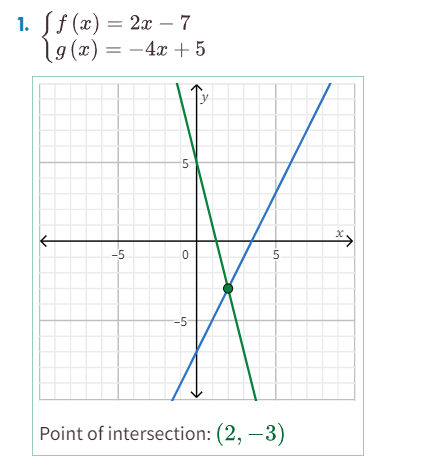

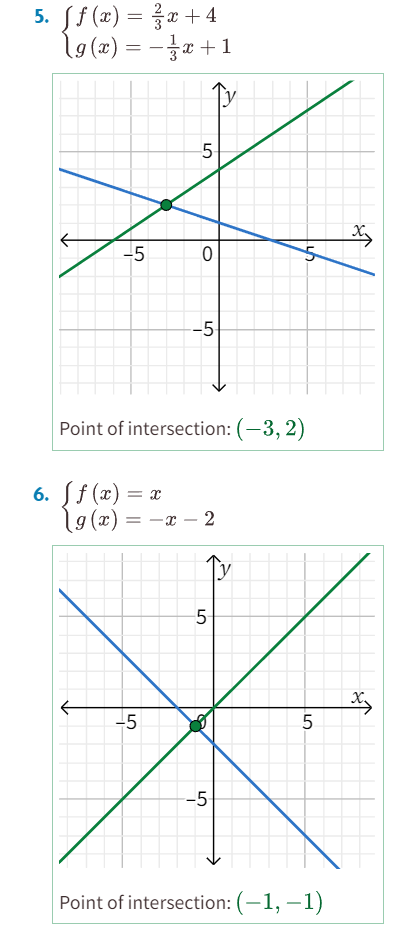

### section 1
#### instruction : Graph each set of linear equations on the same set of axes. Name the coordinates of the point where the two lines intersect.





generate 2 linear equations
1 positive slope 
1 negative negative slope

case 1: pos slope / neg slope

- problem 
- display 2 equations

$\left\{
\begin{array}
f(x)=2 x-7 \\
g(x)=-4 x+5
\end{array}
\right.$

- display empty grid -7 to 7


case 2: fraction slope 1 pos / 1 neg

- problem 
- display 2 equations

$ \left\{\begin{array}{l}
f(x)=\frac{2}{3} x+4 \\
g(x)=-\frac{1}{3} x+1
\end{array}\right.$

case 3: x = int , y = int

- problem 
- display 2 equations


$ \left\{\begin{array}{l}
x= 4 \\
y = 1 
\end{array}\right.$




In [ ]:
#given two functions, find the point of intersection
#fractions inc
#output point of intersection in a (x, y) format
import sympy
import random

def Systems_of_Equation(expr='sympy',option='standard',range_x=3,range_y=3,coeff_mult_range=5):
    '''
    expr = latex , sympy
    option = standard : ax + by = c
          point_slope : y=mx+b 
    range_x = location of solution for x-coordination(evenly distributed -3 to 3 or -10 to 10)
    range_y = location of solution for y-coordination(evenly distributed -3 to 3 or -10 to 10)
    coeff_mult_range= controller for dynamic range shift for the coeff of eqs
    '''
    x, y = sympy.symbols('x y')
    # Generate solution point first
    x = random.randint(-range_x, range_x)
    y = random.randint(-range_y, range_y)
    # Start from reduced echelon form (coeffs 1)
    c1 = [1, 0, x]
    c2 = [0, 1, y]
    def randNonZero():
        return random.choice([i for i in range(-coeff_mult_range, coeff_mult_range) if i != 0])
    # Add random (non-zero) multiple of equations (rows) to each other
    c1_mult = randNonZero()
    c2_mult = randNonZero()
    new_c1 = [c1[i] + c1_mult * c2[i] for i in range(len(c1))]
    new_c2 = [c2[i] + c2_mult * c1[i] for i in range(len(c2))]
    '''
    #For extra randomness, now add random (non-zero) multiples of original rows to themselves
    c1_mult = randNonZero()
    c2_mult = randNonZero()
    new_c1 = [new_c1[i] + c1_mult * c1[i] for i in range(len(c1))]
    new_c2 = [new_c2[i] + c2_mult * c2[i] for i in range(len(c2))]
    '''
    # construct Standard Form
    def standard_form_construct(coeffs): 
        # lots of edge cases for perfect formatting
        x_sign = '-' if coeffs[0] < 0 else ''
        # No redundant 1s
        x_coeff = str(abs(coeffs[0])) #if abs(coeffs[0]) != 1 else ''
        # If x coeff is 0, dont include x
        x_str = f'{x_sign}{x_coeff}*x' if coeffs[0] != 0 else ''
        # if x isn't included and y is positive, dont include operator
        op = ' - ' if coeffs[1] < 0 else (' + ' if x_str != '' else '')
        # No redundant 1s
        y_coeff = abs(coeffs[1]) #if abs(coeffs[1]) != 1 else ''
        # Don't include if 0, unless x is also 0 (probably never happens)
        y_str = f'{y_coeff}*y' #if coeffs[1] != 0 else ('' if x_str != '' else '0')
        lhs = f'{x_str}{op}{y_str}'
        rhs = f'{coeffs[2]}'
        return lhs , rhs
    
    # construct point slope form
    def pointslope_form_construct(coeffs):
        slope = sympy.Rational(-coeffs[0],coeffs[1])
        yint = sympy.Rational(coeffs[2],coeffs[1])
        lhs = 'y'
        rhs = f'{slope}*x + {yint}' if slope != 0 else (f'x + {yint}')
        return lhs , rhs
    
    if option == 'standard':
      eq1lhs , eq1rhs = standard_form_construct(new_c1)
      eq2lhs , eq2rhs = standard_form_construct(new_c2)

    elif option == 'point_slope':
      eq1lhs , eq1rhs = pointslope_form_construct(new_c1)
      eq2lhs , eq2rhs = pointslope_form_construct(new_c2)

    solution = [x,y]

    if expr == 'sympy':  
      return sympy.sympify(eq1lhs), sympy.sympify(eq1rhs), sympy.sympify(eq2lhs), sympy.sympify(eq2rhs), solution
    elif expr == 'latex':
      return sympy.latex(sympy.sympify(eq1lhs)) , sympy.latex(sympy.sympify(eq1rhs)),sympy.latex(sympy.sympify(eq2lhs)),sympy.latex(sympy.sympify(eq2rhs)) , solution

In [ ]:
def Point_Of_Intersection_3_2_1(expr='latex',option='point_slope',range_x=3,range_y=3,coeff_mult_range=5):
  '''
  currently setup for point slope for only for standard for need to change display style. lhs
  EQ1 = first equation
  EQ2 = second equation
  sol = solution for the system
  sol_graph = graphed solution
  '''
  xmin,xmax = -10 , 10
  # generate equations & solutions
  eq1lhs,eq1rhs,eq2lhs,eq2rhs,sol = Systems_of_Equation(expr,option,range_x,range_y,coeff_mult_range)
  #generate empty grids
  empty_graph = emptyGraph(-10,10,-10,10)
  #generate solution_graph
  solution_graph = startGraph() + drawPt(sol) + drawLinear(eq1rhs,xmin,xmax,'black')+ drawLinear(eq1rhs,xmin,xmax,'black')+ endGraph()

  prob = fr'$\begin{{cases}} f(x) ={sympy.latex(eq1rhs)}  \\ g(x) ={sympy.latex(eq2rhs)} \end{{cases}}$'

  sol = f' x = {sol[0]} , y = {sol[1]} or ({sol[0]},{sol[1]})'
  return prob,sol, empty_graph, solution_graph


for i in range(10):
    print(Point_Of_Intersection_3_2_1(expr='sympy',option='standard'))
for i in range(10):
    print(Point_Of_Intersection_3_2_1(expr='sympy',option='point_slope'))

'''
for i in range(10):
    print(Point_Of_Intersection_3_2_1(expr='sympy',option='standard'))
for i in range(10):
    print(Point_Of_Intersection_3_2_1(expr='latex',option='standard'))
'''


('$\\begin{cases} f(x) =2  \\\\ g(x) =-10 \\end{cases}$', ' x = 2 , y = 0 or (2,0)', '\\begin{tikzpicture}\\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\\end{axis}\\end{tikzpicture}', '\\begin{tikzpicture}\\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\\fill[draw=black,fill=black] (axis cs: 2,0) circle(2pt);\\addplot[domain=-10:10, color=black,]{2};\\addplot[domain=-10:10, color=black,]{2};\\end{axis}\\end{tikzpicture}')
('$\\begin{cases} f(x) =5  \\\\ g(x) =4 \\end{cases}$', ' x = 1 , y = 1 or (1,1)', '\\begin{tikzpicture}\\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\\end{axis}\\end{tikzpicture}', '\\begin{tikzpicture}\\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\\fill[draw=black,fill=black] (axis cs: 1,1) circle(2pt);\\addplot[domain=-10:1

"\nfor i in range(10):\n    print(Point_Of_Intersection_3_2_1(expr='sympy',option='standard'))\nfor i in range(10):\n    print(Point_Of_Intersection_3_2_1(expr='latex',option='standard'))\n"

## AGS1.3.2.2 - Increasin / Decreasing / Constant / Domain & Range

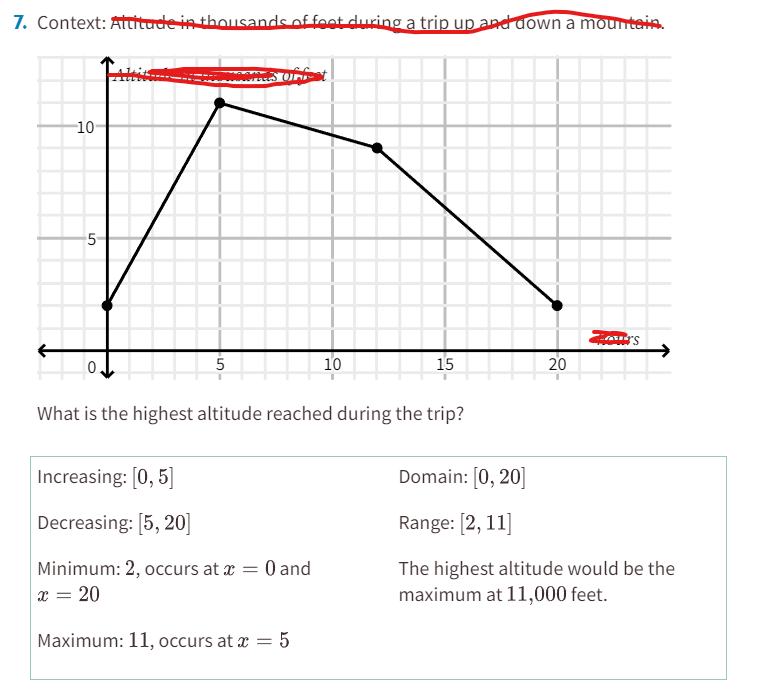

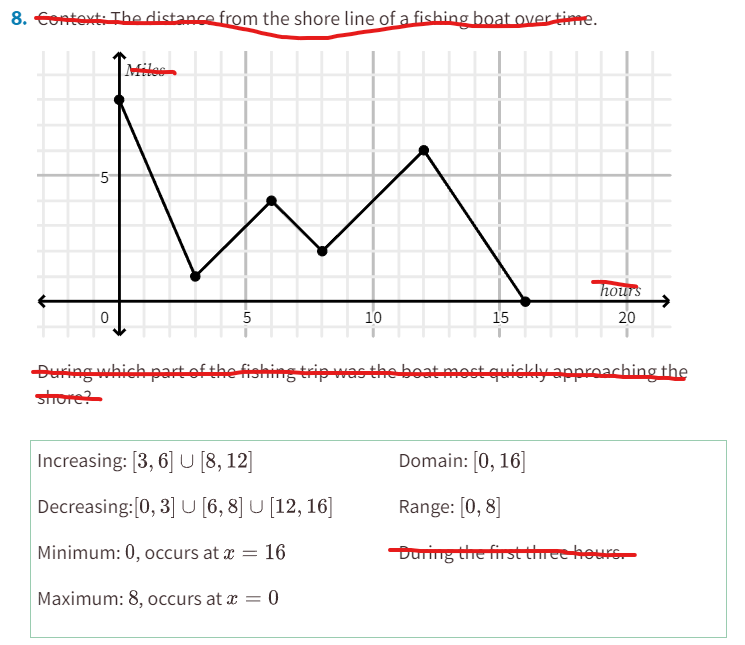

### section 1: lienar function

#### instruction : For each graph and description do the following:

- use interval notation to state where the function is increasing or decreasing
- state the minimum or maximum if the function has them
- write the domain and range of the function using interval notation
- respond to the context-based question

answer
- Increasing : 
- Decreasing : 
- Minumum : 
- Maximum : 
- Domain : 
- Range : 

In [ ]:
#prequisite

r"""
\documentclass{article} 
\usepackage{pgfplots} 
\usetikzlibrary{intersections}
\usetikzlibrary{patterns}
"""

In [ ]:
# for generating data, create a "range" of +/3 that the randomizer can choose from (up or down)
import random
import sympy
import numpy as np

def upAndDownGraph():
    problem = ""
    answer = ""

    x_points = []
    points = []

    x = 1
    x_points.append(x)
    points.append(np.random.randint(low = 0, high = 100) )

    for i in range( random.randint(4,10) ):
        x+=1
        x_points.append(x)
        points.append(np.random.randint(low = points[-1] - 3, high = points[-1] + 3))

    return x_points, points

def indexcount(obj, data):
    number_of = data.count(obj)
    saved = []
    if number_of > 1:
        temp = data
        for i in range(number_of):
            saved.append(data.index(obj))
            temp = temp[saved[-1] + 1:]
        # splice, then index again
    else:
        saved.append(data.index(obj))
    return saved


def compress_d(increasing, decreasing, stagnant):
    print(increasing)
    prev = 0
    for i in range(len(increasing)):
        if i+1 != len(increasing): # get rid of overstepping allocated index (approachable index)
            if increasing[i] + 1 == increasing[i+1]:
                increasing[i] = fr'[{increasing[i]}, {increasing[i+1]}]' # replace to [{one}, {two}], then replace as needed. No need to touch more since it already creates it in interval notation. join(''.join) the list with \cap for union
                # close the front in
                #increasing[i+1]
                # domains not properly compressing (only pairing

    print(decreasing)
    for i in range(len(decreasing)):
        if i+1 != len(decreasing):
            if decreasing[i] - 1 == decreasing[i+1]:
                decreasing[i] = fr'[{decreasing[i]}, {decreasing[i+1]}]'

    print(stagnant)
    for i in range(len(stagnant)):
        if i+1 != len(stagnant):
            if stagnant[i] == stagnant[i+1]:
                stagnant[i] = fr'[{stagnant[i]}, {stagnant[i+1]}]'

    return increasing, decreasing, stagnant


def graph_movement_conf(data, x):
    previous = 0
    continuousity = 0
    increasing = []
    decreasing = []
    stagnant = []

    for i in range(len(data)):
        temp = data[i]
        if temp > previous:
            #increasing
            continuousity+=1
            increasing.append(x[i])

        elif temp < previous:
            # decreasing
            continuousity+=1
            decreasing.append(x[i])

        elif temp == previous:
            # stagnant
            continuousity+=1
            stagnant.append(x[i])

        else:
            # disconect (discontinuous graph)
            continuousity=0

        previous = temp

    return compress_d(increasing, decreasing, stagnant)


def analyize_data(x, data):
    """
    look for max, min, median,possible ticks
    """
    details = []
    x_minimum = 0
    x_maximum = 0

    y_maximum = 0
    y_minimum = 0
    range_of_values = 0
    possible_ticks = 0
    numberTerms = x[-1]
    parsed_x_ticker = ""
    parsed_y_ticker = ""

    xvals = x
    xvals.sort()

    x_minimum = xvals[0]
    x_maximum = xvals[-1]

    copy = data
    copy.sort()

    y_maximum = copy[-1]
    y_minimum = copy[0]

    # WORKING ON THIS
    # calculate increase, decrease, minimum, maximum, domain, range
    details = []
    print(graph_movement_conf(data, x))
    details.append([]) #increasing
    details.append([]) #decreasing
    details.append(indexcount(y_minimum, data)) #minimum (multiple instances)
    # need indexcount interpreter
    details.append(indexcount(y_maximum, data)) #maximum
    details.append([xvals[0], xvals[-1]]) #domain (might have to add number of domains index later) ( do this after increasing and decreasing analization )
    details.append([copy[0], copy[-1]])#range

    print(details)

    """Increasing :
    Decreasing :
    Minumum :
    Maximum :
    Domain :
    Range :"""

    #print(y_minimum, y_maximum)
    range_of_values = y_maximum - y_minimum
    #print(range_of_values)

    if (range_of_values / numberTerms) < 1:
        # single ticker for y
        temp = y_minimum - random.randint(1,5)
        y_minimum = temp
        temp2 = y_maximum + random.randint(0,5)
        y_maximum = temp2
        parsed_y_ticker = fr"`{temp}, {temp + 1}, ..., {temp2}~"
        parsed_y_ticker=parsed_y_ticker.replace("`", "{")
        parsed_y_ticker=parsed_y_ticker.replace("~", "}")

    parsed_x_ticker = fr'`{x[0]}, {x[1]}, ..., {x[-1] + 1}~' # x1, x2, ..., xn
    parsed_x_ticker=parsed_x_ticker.replace("`", "{")
    parsed_x_ticker=parsed_x_ticker.replace("~", "}")

    #print("here", parsed_x_ticker, parsed_y_ticker)

    return x, data, x_minimum, x_maximum, y_minimum, y_maximum, parsed_x_ticker, parsed_y_ticker

def graph_gen(x, data, x_minimum, x_maximum, y_minimum, y_maximum, parsed_x_ticker, parsed_y_ticker):
    """
    data will come prepackaged in the form of a 2-d list
    x being the x values
    y being the randomized near values
    """
    out = []
    inputted = ""

    out.append(r'\begin{tikzpicture}\begin{axis}[axis on top,smooth,axis line style=very thick,axis x line=bottom,axis y line=left,grid=major,')
    out.append(fr'xmin={x_minimum}, xmax={x_maximum},ymin={y_minimum}, ymax={y_maximum},xtick={parsed_x_ticker},ytick={parsed_y_ticker}]')
    out.append(r'\addplot[mark=*,black] plot coordinates {')
    for i in range(len(x)): out.append(fr'({x[i]}, {data[i]})')
    out.append(r'};')
    out.append(r'\end{axis}')
    out.append(r'\end{tikzpicture}')
    return ''.join(out)

for i in range(10):
    one, two = upAndDownGraph()
    print("--<")
    print(graph_gen(*analyize_data(one, two)))
    print(">--")

--<
[1, 2, 3, 4, 6, 8, 11]
[]
[5, 7, 9, 10]
(['[1, 2]', '[2, 3]', '[3, 4]', 4, 6, 8, 11], [], [5, 7, 9, 10])
[[], [], [0], [10], [1, 11], [42, 50]]
\begin{tikzpicture}\begin{axis}[axis on top,smooth,axis line style=very thick,axis x line=bottom,axis y line=left,grid=major,xmin=1, xmax=11,ymin=40, ymax=50,xtick={1, 2, ..., 12},ytick={40, 41, ..., 50}]\addplot[mark=*,black] plot coordinates {(1, 42)(2, 43)(3, 44)(4, 45)(5, 45)(6, 46)(7, 46)(8, 49)(9, 49)(10, 49)(11, 50)};\end{axis}\end{tikzpicture}
>--
--<
[1, 2, 4]
[]
[3, 5]
(['[1, 2]', 2, 4], [], [3, 5])
[[], [], [0], [3, 3], [1, 5], [4, 7]]
\begin{tikzpicture}\begin{axis}[axis on top,smooth,axis line style=very thick,axis x line=bottom,axis y line=left,grid=major,xmin=1, xmax=5,ymin=1, ymax=9,xtick={1, 2, ..., 6},ytick={1, 2, ..., 9}]\addplot[mark=*,black] plot coordinates {(1, 4)(2, 5)(3, 5)(4, 7)(5, 7)};\end{axis}\end{tikzpicture}
>--
--<
[1, 2, 5, 7, 11]
[]
[3, 4, 6, 8, 9, 10]
(['[1, 2]', 2, 5, 7, 11], [], [3, 4, 6, 8, 9, 10])
[[],

In [ ]:
def PWLinearChars(expr='latex'):
    endPts, pairs = [0], []

    for jj in range(randint(3,5)):
        slope = Rational(getInt(-6,6),randint(1,3))
        if jj == 0:
            func = LinFunc(slope, randint(-8,8))
        else:
            start = pairs[-1][0].subs(x,endPts[jj])
            func = LinFunc(slope, [endPts[jj],start])
        
        step = randint(3,6) if slope.q==1 else randint(1,3)*slope.q
        endPts.append(endPts[jj] + step)
        pairs.append([func.expr, fr'[{endPts[jj]},{endPts[jj+1]}]'])
    
    func = PWFunc(*pairs)

    problem = graphPW(func, contDot=True)

    rangeset = func.getRange()
    mins, maxes = func.solve(rangeset.inf), func.solve(rangeset.sup)
    
    inc, dec, const = EmptySet, EmptySet, EmptySet
    for expr, interval in func.pairs:
        if expr.coeff(x) > 0:
            inc = inc.union(interval)
        elif expr.coeff(x) < 0:
            dec = dec.union(interval)
        else:
            const = const.union(interval)

    answer = 'Domain: ' + signify(latex(func.domain)) + r'\newline '
    answer += 'Range: ' + signify(latex(rangeset)) + r'\newline '
    answer += 'Increasing: ' + (signify(latex(inc)) if inc!=EmptySet else 'None') + r'\newline '
    answer += 'Decreasing: ' + (signify(latex(dec)) if dec!=EmptySet else 'None') + r'\newline '
    answer += 'Constant: ' + (signify(latex(const)) if const!=EmptySet else 'None') + r'\newline '
    answer += 'Minimum: ' + signify(latexify(rangeset.inf)) + ', occurs at $x=' + str(mins)[1:-1] + r'$ \newline '
    answer += 'Maximum: ' + signify(latexify(rangeset.sup)) + ', occurs at $x=' + str(maxes)[1:-1] + r'$ \newline '

    return problem, answer

for jj in range(5):
    problem, answer = PWLinearChars()
    print(problem)
    print(answer)

\begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-1,xmax=21,xtick={-5,0,...,26},ymin=-26,ymax=1,ytick={-30,-25,...,6},]\addplot[black,solid,thick,domain=0:4,samples=100] {-5*x - 4};\fill[draw=black,fill=black] (axis cs: 0,-4) circle(2pt);\addplot[black,solid,thick,domain=4:7,samples=100] {6*x - 48};\fill[draw=black,fill=black] (axis cs: 4,-24) circle(2pt);\addplot[black,solid,thick,domain=7:13,samples=100] {1 - x};\fill[draw=black,fill=black] (axis cs: 7,-6) circle(2pt);\addplot[black,solid,thick,domain=13:18,samples=100] {x - 25};\fill[draw=black,fill=black] (axis cs: 13,-12) circle(2pt);\fill[draw=black,fill=black] (axis cs: 18,-7) circle(2pt);\end{axis}\end{tikzpicture}
Domain: $\left[0, 18\right]$\newline Range: $\left[-24, -4\right]$\newline Increasing: $\left[4, 7\right] \cup \left[13, 18\right]$\newline Decreasing: $\left[0, 4\right] \cup \left[7, 13\right]$\newline Constant: None\newline Minimum: $-24$, occurs at $x=4$ \newline Maximum: $-4$, occurs at $x=0$ \newline 
\begin

### section 2 : table
#### instruction : For each graph and description do the following:

- use interval notation to state where the function is increasing or decreasing
- state the minimum or maximum if the function has them
- write the domain and range of the function using interval notation
- respond to the context-based question

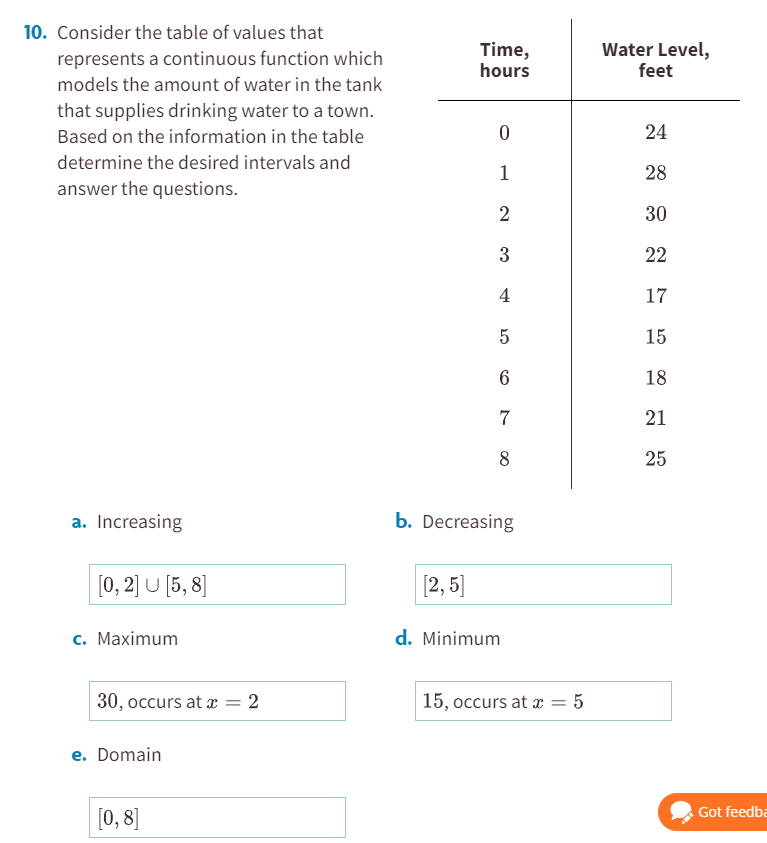

## AGS1.3.3.1 - Fill In The Table & State The Point Of Intersection

## section 1:
### instruction : Fill in the table of values for each of the linear functions. Then state the point of intersection of the two lines.

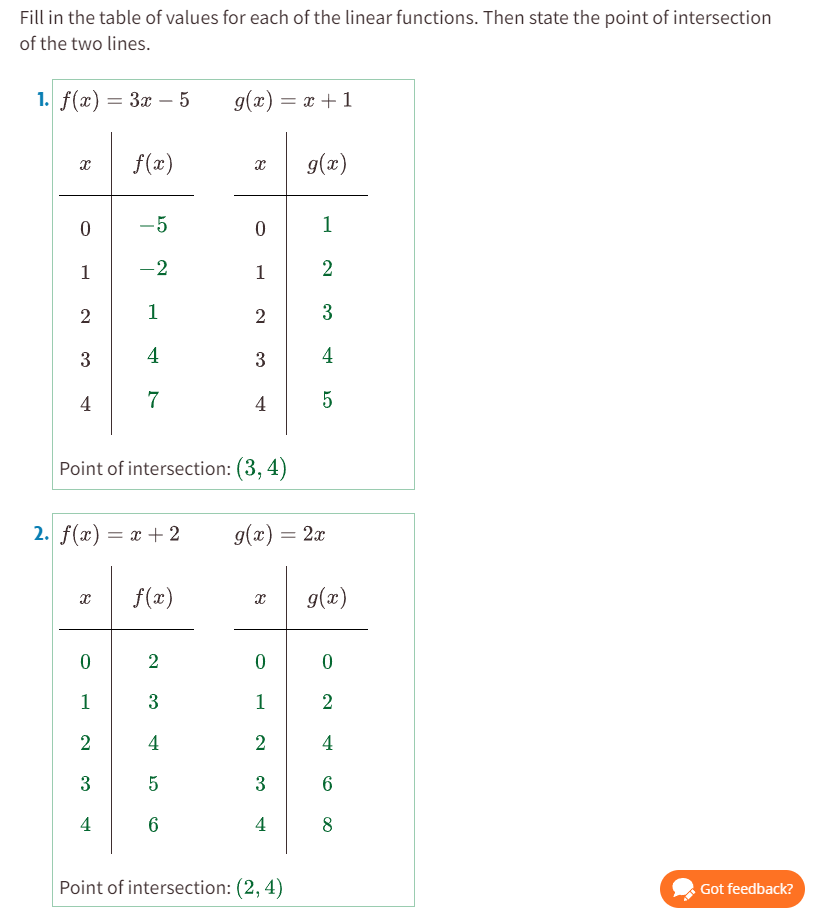

In [ ]:
def LinSysTable_3_3_1(expr='latex'):
    pt = [randint(0,4),randint(-10,10)]
    func1 = LinFunc(getInt(-4,4), pt)
    func2 = LinFunc(getInt(-4,4, exclude=[0,func1.slope]), pt, label='g')

    left = signify(func1.getSlopeInt()) + func1.getTable(range(5),vals=False)
    right = signify(func2.getSlopeInt()) + func2.getTable(range(5),vals=False)
    problem = minipagify(left, right)
    problem += 'Point of intersection:'

    left = signify(func1.getSlopeInt()) + func1.getTable(range(5))
    right = signify(func2.getSlopeInt()) + func2.getTable(range(5))
    answer = minipagify(left, right)
    answer += fr'Point of intersection: $({pt[0]},{pt[1]})$'

    return problem, answer

for jj in range(5):
    problem, answer = LinSysTable_3_3_1()
    print(problem, r'\\')
    print(answer, r'\\')

\begin{minipage}[t]{0.5\textwidth}
$f(x) = -2x + 9${\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$x$ & $f(x)$ \\
			\hline
			$0$ & \phantom{$9$} \\
			\hline
			$1$ & \phantom{$7$} \\
			\hline
			$2$ & \phantom{$5$} \\
			\hline
			$3$ & \phantom{$3$} \\
			\hline
			$4$ & \phantom{$1$} \\
			\hline
		\end{tabular}
	\end{center}}
\end{minipage}
\begin{minipage}[t]{0.5\textwidth}
$g(x) = -4x + 13${\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$x$ & $g(x)$ \\
			\hline
			$0$ & \phantom{$13$} \\
			\hline
			$1$ & \phantom{$9$} \\
			\hline
			$2$ & \phantom{$5$} \\
			\hline
			$3$ & \phantom{$1$} \\
			\hline
			$4$ & \phantom{$-3$} \\
			\hline
		\end{tabular}
	\end{center}}
\end{minipage}

\vspace{0.25in}
Point of intersection: \\
\begin{minipage}[t]{0.5\textwidth}
$f(x) = -2x + 9${\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$x$ & $f(x)$ \\
			\hline
			$0$ 

#Misc